In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


In [3]:
class CaptionClassifierDataset(Dataset):
    def __init__(self, captions, references, occlusions, labels, tokenizer, max_length=512):
        self.captions = captions
        self.references = references
        self.occlusions = occlusions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        caption = str(self.captions[idx])
        reference = str(self.references[idx])
        occlusion = str(self.occlusions[idx])
        
        # Format input as: <original_caption> <SEP> <generated_caption> <SEP> <perturbation_percentage>
        text = reference + " [SEP] " + caption + " [SEP] " + occlusion
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [4]:
class CaptionClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=2, dropout_prob=0.1):
        super(CaptionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Use the [CLS] token representation for classification
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits


In [ ]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs  # model directly returns logits
            predictions = torch.argmax(logits, dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    return {
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }

In [ ]:
def train_classifier(model, dataloader, optimizer, criterion, device, epochs):
    model.train()
    total_loss = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        progress_bar = tqdm(dataloader, desc="Training")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
            
        avg_loss = total_loss / len(dataloader)
        print(f"Average training loss: {avg_loss}")
        
        # Evaluate on validation set
        val_metrics = evaluate_classifier(model, val_dataloader, device)
        print(f"Validation metrics: {val_metrics}")
        
    return model

In [ ]:
df = pd.read_csv("occluded_image_captions.csv")

# Prepare labels (0 for SmolVLM, 1 for VIT-GPT2)
df['label'] = df['model'].apply(lambda x: 1 if x == 'vit-gpt2' else 0)

# Split the dataset by images (70% train, 10% validation, 20% test)
# First, get unique image indices
unique_indices = df['Unnamed: 0'].unique()
np.random.shuffle(unique_indices)

# Split indices
train_size = int(0.7 * len(unique_indices))
val_size = int(0.1 * len(unique_indices))

train_indices = unique_indices[:train_size]
val_indices = unique_indices[train_size:train_size+val_size]
test_indices = unique_indices[train_size+val_size:]

# Create train, validation, and test dataframes
train_df = df[df['Unnamed: 0'].isin(train_indices)]
val_df = df[df['Unnamed: 0'].isin(val_indices)]
test_df = df[df['Unnamed: 0'].isin(test_indices)]

In [10]:


# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = CaptionClassifierDataset(
    train_df['caption'].values,
    train_df['reference'].values,
    train_df['occlusion'].values,
    train_df['label'].values,
    tokenizer
)

val_dataset = CaptionClassifierDataset(
    val_df['caption'].values,
    val_df['reference'].values,
    val_df['occlusion'].values,
    val_df['label'].values,
    tokenizer
)

test_dataset = CaptionClassifierDataset(
    test_df['caption'].values,
    test_df['reference'].values,
    test_df['occlusion'].values,
    test_df['label'].values,
    tokenizer
)

In [12]:


# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = CaptionClassifier()
model.to(device)

# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Train the model
epochs = 10
model = train_classifier(model, train_dataloader, optimizer, criterion, device, epochs)

Epoch 1/10


Training: 100%|██████████| 325/325 [02:46<00:00,  1.95it/s, loss=0.0123] 


Average training loss: 0.12829833667080562
Validation metrics: {'accuracy': 0.9973045822102425}
Epoch 2/10


Training: 100%|██████████| 325/325 [02:41<00:00,  2.01it/s, loss=0.0008]  


Average training loss: 0.14195443344714406
Validation metrics: {'accuracy': 0.9986522911051213}
Epoch 3/10


Training: 100%|██████████| 325/325 [02:42<00:00,  2.00it/s, loss=0.00336] 


Average training loss: 0.15107138632416117
Validation metrics: {'accuracy': 1.0}
Epoch 4/10


Training: 100%|██████████| 325/325 [02:43<00:00,  1.99it/s, loss=0.000285]


Average training loss: 0.15394955185750195
Validation metrics: {'accuracy': 0.9973045822102425}
Epoch 5/10


Training: 100%|██████████| 325/325 [02:43<00:00,  1.99it/s, loss=7.74e-5] 


Average training loss: 0.15433753121001736
Validation metrics: {'accuracy': 1.0}
Epoch 6/10


Training: 100%|██████████| 325/325 [02:47<00:00,  1.94it/s, loss=5.85e-5] 


Average training loss: 0.15441969547646855
Validation metrics: {'accuracy': 1.0}
Epoch 7/10


Training: 100%|██████████| 325/325 [02:44<00:00,  1.98it/s, loss=5.14e-5] 


Average training loss: 0.15447315442163156
Validation metrics: {'accuracy': 1.0}
Epoch 8/10


Training: 100%|██████████| 325/325 [02:42<00:00,  2.00it/s, loss=3.47e-5] 


Average training loss: 0.15451301999069422
Validation metrics: {'accuracy': 1.0}
Epoch 9/10


Training: 100%|██████████| 325/325 [02:42<00:00,  2.00it/s, loss=2.45e-5]


Average training loss: 0.15454390703702162
Validation metrics: {'accuracy': 1.0}
Epoch 10/10


Training: 100%|██████████| 325/325 [02:42<00:00,  2.00it/s, loss=2.17e-5]


Average training loss: 0.15456844674991982
Validation metrics: {'accuracy': 1.0}


In [20]:
# Evaluate on test set
test_metrics = evaluate_classifier(model, test_dataloader, device)
print(f"Test metrics: {test_metrics}")

# Save the model
torch.save(model.state_dict(), "caption_classifier.pt")

[[743   1]
 [  3 739]]
{'0': {'precision': 0.9959785522788204, 'recall': 0.9986559139784946, 'f1-score': 0.9973154362416108, 'support': 744.0}, '1': {'precision': 0.9986486486486487, 'recall': 0.9959568733153639, 'f1-score': 0.9973009446693657, 'support': 742.0}, 'accuracy': 0.9973082099596231, 'macro avg': {'precision': 0.9973136004637345, 'recall': 0.9973063936469293, 'f1-score': 0.9973081904554882, 'support': 1486.0}, 'weighted avg': {'precision': 0.9973118036290308, 'recall': 0.9973082099596231, 'f1-score': 0.9973082002075556, 'support': 1486.0}}
Test metrics: {'accuracy': 0.9973082099596231, 'confusion_matrix': array([[743,   1],
       [  3, 739]]), 'classification_report': {'0': {'precision': 0.9959785522788204, 'recall': 0.9986559139784946, 'f1-score': 0.9973154362416108, 'support': 744.0}, '1': {'precision': 0.9986486486486487, 'recall': 0.9959568733153639, 'f1-score': 0.9973009446693657, 'support': 742.0}, 'accuracy': 0.9973082099596231, 'macro avg': {'precision': 0.997313600

🔍 Evaluation Results
------------------------------
✅ Accuracy: 0.9973

📊 Classification Report:
              precision  recall  f1-score   support
0                 0.996   0.999     0.997   744.000
1                 0.999   0.996     0.997   742.000
accuracy          0.997   0.997     0.997     0.997
macro avg         0.997   0.997     0.997  1486.000
weighted avg      0.997   0.997     0.997  1486.000

🧾 Confusion Matrix:
[[743   1]
 [  3 739]]


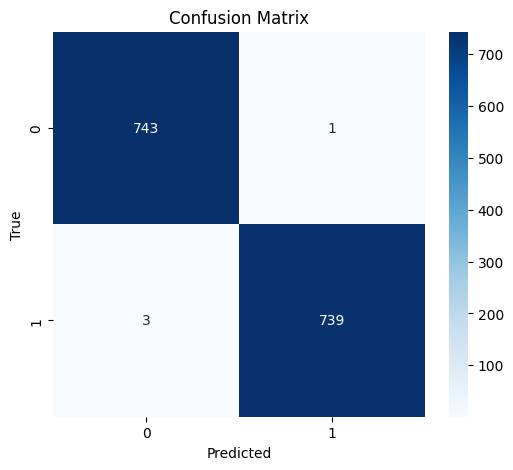

In [23]:
results = test_metrics

print("🔍 Evaluation Results")
print("-" * 30)

# Accuracy
print(f"✅ Accuracy: {results['accuracy']:.4f}\n")

# Classification Report
print("📊 Classification Report:")
class_report_df = pd.DataFrame(results["classification_report"]).transpose()
print(class_report_df.round(3))

# Confusion Matrix
print("\n🧾 Confusion Matrix:")
conf_matrix = results["confusion_matrix"]
print(conf_matrix)

# Optional: Visual Confusion Matrix (if you're in notebook or script with GUI)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()